**Utilize Additional Statistical and Econometric Models to Refine the Analysis:**


*   Advanced time series models such as VAR (Vector Autoregression) for multivariate time series analysis.
*   Regime-switching models like Markov-Switching ARIMA to capture different market conditions

*  Implement machine learning models like LSTM (Long Short-Term Memory) networks for capturing complex patterns and dependencies in the data.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import joblib
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score

# **Load dataset**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/change point analysis/data/processed_data.csv')

# **ARIMA Model**
Check Stationarity Using ADF Test

ARIMA works well for stationary time series.


In [4]:
#check stationarity
result = adfuller(df['Price'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Lag used: {result[2]}")
print(f"Number of observation: {result[2]}")
print(f"Critical Values': {result[4]}")

if result[1] < 0.05:
    print("Data is stationary (No need for differencing)")
else:
    print("Data is non-stationary (Differencing needed)")

ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287
Lag used: 29
Number of observation: 29
Critical Values': {'1%': -3.4310783342658615, '5%': -2.861861876398633, '10%': -2.566941329781918}
Data is non-stationary (Differencing needed)


#**Apply First-Order Differencing**

Since the data is non-stationary, we apply first-order differencing to make it stationary before using ARIMA.

In [5]:
df['Price_diff'] = df['Price'].diff().dropna()

# Re-run ADF test on differenced data

result_diff = adfuller(df['Price_diff'].dropna())

print(f"ADF Statistic (Differenced): {result_diff[0]}")
print(f"p-value (Differenced): {result_diff[1]}")

if result_diff[1] < 0.05:
    print("Data is now stationary (Differencing successful)")
else:
    print("Data is still non-stationary (Further differencing may be needed)")


ADF Statistic (Differenced): -15.52936758004802
p-value (Differenced): 2.230740510516298e-28
Data is now stationary (Differencing successful)


# **Fit ARIMA Model**

In [27]:
def train_test_split(df):
    train_df=df[:round(len(df)*0.8)]
    test_df=df[round(len(df)*0.8):]

    return train_df,test_df
train_df,test_df=train_test_split(df)

In [11]:
arima_model=ARIMA(train_df['Price'],order=(1,1,1))
model = arima_model.fit()

prediction = model.forecast(steps=len(test_df))

predicted_Price=pd.Series(prediction,name='predicted_Price')
actual_vs_prediction=test_df
actual_vs_prediction['predicted_Price']=predicted_Price.values

# Assuming y_true and y_pred are your true and predicted values
y_true = df['Price']  # Replace with actual values
y_pred = actual_vs_prediction['predicted_Price'] # Replace with actual predicted values

<ipython-input-11-dd6199b5c294>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_vs_prediction['predicted_Price']=predicted_Price.values


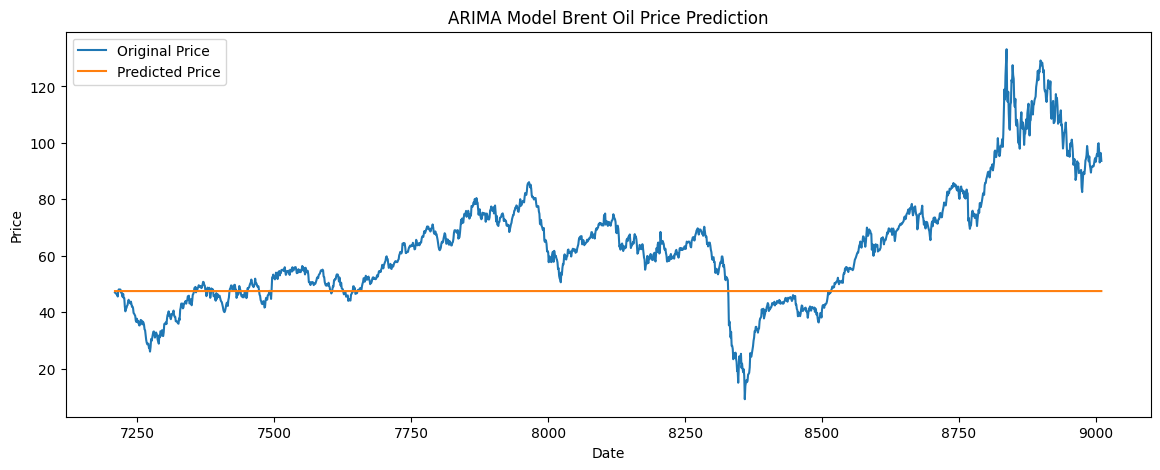

In [18]:
# plot actual_vs_prediction
plt.figure(figsize=(14, 5))
plt.plot(actual_vs_prediction.index, actual_vs_prediction['Price'], label="Original Price")
plt.plot(actual_vs_prediction.index,actual_vs_prediction['predicted_Price'], label="Predicted Price")
plt.title('ARIMA Model Brent Oil Price Prediction')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# **Model Metrics**

In [19]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2_Score=r2_score(y_true,y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE as a percentage

# Print metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R Square Score (r2_score):", r2_Score)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

Mean Absolute Error (MAE): 19.250491235722876
Mean Squared Error (MSE): 662.1050673025213
Root Mean Squared Error (RMSE): 25.731402357868514
R Square Score (r2_score): -0.5547176759961145
Mean Absolute Percentage Error (MAPE): 28.53168011088833 %


In [24]:
# Save the model using pickle
ARIMA_MODEL = '/content/drive/MyDrive/change point analysis/model/arima_model.pkl'  # Define the filename with the full path
with open(ARIMA_MODEL, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved as {ARIMA_MODEL}")

Model saved as /content/drive/MyDrive/change point analysis/model/arima_model.pkl


# **LSTM Modelling**
LSTM works well for complex, long-term dependencies in data.

In [26]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df[['Price']])

In [ ]:
def train_test_split(df):
    train_df=df[:round(len(df)*0.8)]
    test_df=df[round(len(df)*0.8):]

    return train_df,test_df
train_df,test_df=train_test_split(df_scaled)

In [43]:
# Create sequences for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Set time step (60 days)
time_step = 30
X_train, y_train = create_dataset(df_scaled, time_step)
X_test, y_test = create_dataset(df_scaled, time_step)

In [31]:
# Reshape data to be compatible with LSTM input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# **Build LSTM Model**

In [44]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


562/562 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - loss: 0.0041 - val_loss: 3.2432e-04
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 35s 40ms/step - loss: 3.8409e-04 - val_loss: 2.6129e-04
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 3.1777e-04 - val_loss: 4.8819e-04
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - loss: 2.3570e-04 - val_loss: 2.0852e-04
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - loss: 1.9133e-04 - val_loss: 1.9783e-04
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 1.4646e-04 - val_loss: 1.2233e-04
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 43s 41ms/step - loss: 1.3601e-04 - val_loss: 1.0642e-04
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 1.2237e-04 - val_loss: 1.0849e-04
Epoch 9/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 1.1714e-04 - val_loss: 2.0521e-04
Epoch 10/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 1.2580e-04 - val_loss: 1.2837e-04


In [45]:
# Make predictions on the test set
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


# **Model metrics**

In [46]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2_Score=r2_score(y_true,y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Print metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R Square Score (r2_score):", r2_Score)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

Mean Absolute Error (MAE): 19.250491235722876
Mean Squared Error (MSE): 662.1050673025213
Root Mean Squared Error (RMSE): 25.731402357868514
R Square Score (r2_score): -0.5547176759961145
Mean Absolute Percentage Error (MAPE): 0.2853168011088833 %


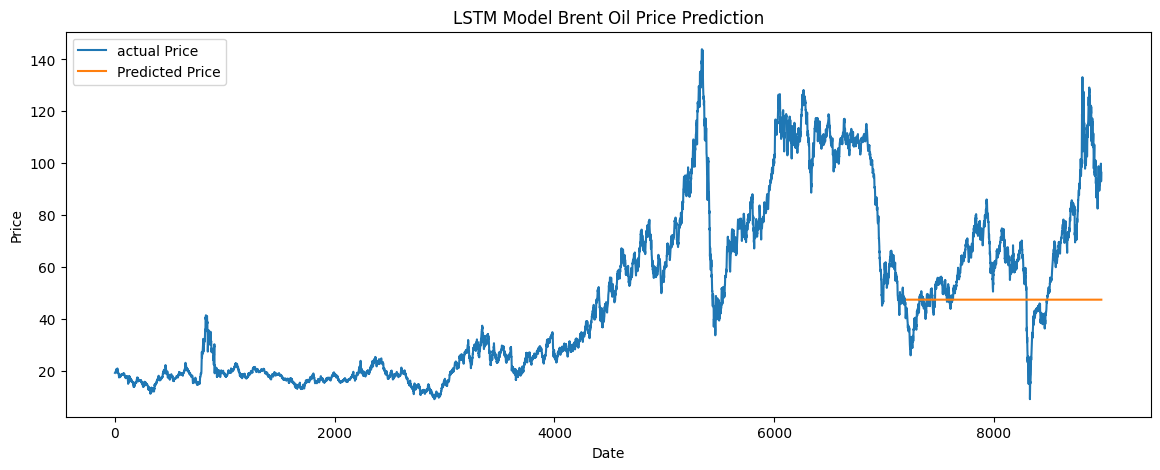

In [47]:
actual_vs_prediction=pd.DataFrame(y_test, columns=["Price"])
actual_vs_prediction["predicted_Price"]=pd.DataFrame(y_pred)

plt.figure(figsize=(14, 5))
plt.plot(actual_vs_prediction.index, actual_vs_prediction['Price'], label="actual Price")
plt.plot(actual_vs_prediction.index,actual_vs_prediction['predicted_Price'], label="Predicted Price")
plt.title('LSTM Model Brent Oil Price Prediction')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [48]:
# Save the model using pickle
LSTM_MODEL = '/content/drive/MyDrive/change point analysis/model/lstm_model.pkl'  # Define the filename with the full path
with open(LSTM_MODEL, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved as {LSTM_MODEL}")

Model saved as /content/drive/MyDrive/change point analysis/model/lstm_model.pkl
